# Quantum Newton Raphson on Net0 with VQLS linear solver and noise model

In this example, we use the VQLS solver to drive the Newton-Raphson algorithm to obtain the pressure and flow rate of a small network, Net0:

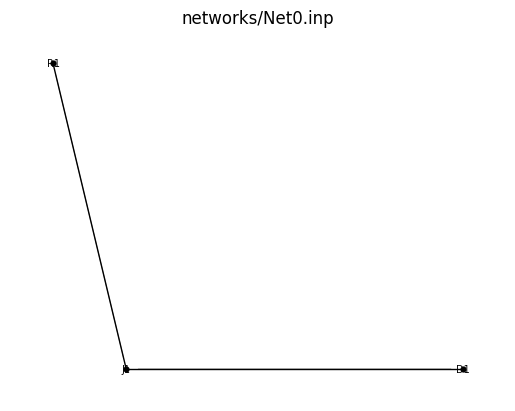

<Axes: title={'center': 'networks/Net0.inp'}>

In [1]:
import os
import wntr
import wntr_quantum

os.environ["EPANET_TMP"] = "/Users/murilo/scratch_dir/.epanet_quantum"
os.environ["EPANET_QUANTUM"] = "/Users/murilo/Documents/NLeSC_Projects/Vitens/EPANET"

# set up network model
inp_file = "networks/Net0.inp"
wn = wntr.network.WaterNetworkModel(inp_file)

# plot network
wntr.graphics.plot_network(wn, title=wn.name, node_labels=True)

### Solve model using the classical Epanet simulator

We now solve the same problem using the classical Epanet simulator. Note that, by default, `QuantumEpanetSimulator` uses a classical `CholeskySolver` to iteratively solve the linear problem.

In [ ]:
# define the classical EPANET simulator
sim = wntr.sim.EpanetSimulator(wn)

# run the EPANET simulation
results_epanet = sim.run_sim()

# save number of nodes and pipes
n_nodes = (len(results_epanet.node["pressure"].iloc[0]),)
n_pipes = len(results_epanet.link["flowrate"].iloc[0])

results_epanet.node["pressure"], results_epanet.link["flowrate"]

Your EPANET quantum path: /Users/murilo/Documents/NLeSC_Projects/Vitens/EPANET
Your EPANET temp dir: /Users/murilo/scratch_dir/.epanet_quantum

* Size of the Jacobian in EPANET simulator: 2
* Size of the b vector in EPANET simulator: 2


(name         J1         D1            R1
 0     29.647690  19.167675 -9.338379e-07
 3600  29.647692  19.167675 -9.338379e-07,
 name    P1    P2
 0     0.05  0.05
 3600  0.05  0.05)

### Solve water network with `QuantumEpanetSimulator` and VQLS 

We now solve the model using VQLS and a noisy model.

In [ ]:
import numpy as np

from qiskit.circuit.library import RealAmplitudes
from qiskit.primitives import Estimator
from qiskit_algorithms import optimizers as opt

from qiskit_aer import AerSimulator
from qiskit_aer.primitives import EstimatorV2 as qiskit_aer_EstimatorV2
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit_ibm_runtime.fake_provider import FakeManilaV2
from qiskit_ibm_runtime import QiskitRuntimeService

from quantum_newton_raphson.vqls_solver import VQLS_SOLVER
from utils import compare_results 

n_qubits = 1

# create a noise model from a backend
# the model is created from a real hardware
service = QiskitRuntimeService()
# real_hardware = service.backend("ibm_kyoto")  # => asking for a specific backend
real_hardware = service.least_busy()
print(f"* Building a noise model from a real ibm hardware: {real_hardware.name}")
noise_model = NoiseModel.from_backend(real_hardware)

# noise_model = NoiseModel()
# cx_depolarizing_prob = 0.001  # => add later a 0.1% on every two-qubit CNOT gate
# noise_model.add_all_qubit_quantum_error(
#     depolarizing_error(cx_depolarizing_prob, 2), ["cx"]
# )

# set up quantum backend and estimator
backend = AerSimulator()
estimator = qiskit_aer_EstimatorV2(
    options=dict(
        backend_options=dict(noise_model=noise_model),
        run_options=dict(shots=10_000, seed=42),
    )
)

qc = RealAmplitudes(n_qubits, reps=3, entanglement="full")

linear_solver = VQLS_SOLVER(
    estimator=estimator,
    ansatz=qc,
    optimizer=[opt.COBYLA(maxiter=1000, disp=True), opt.CG(maxiter=500, disp=True)],
    matrix_decomposition="pauli",
    verbose=True,
    preconditioner="diagonal_scaling",
    reorder=True,
)

sim = wntr_quantum.sim.QuantumEpanetSimulator(wn, linear_solver=linear_solver)
results_vqls = sim.run_sim(linear_solver=linear_solver)

results_classical, results_quantum = compare_results(results_epanet, results_vqls)

results_vqls.node["pressure"], results_vqls.link["flowrate"]

* Building a noise model from a real ibm hardware: ibm_brisbane


100%|██████████| 4/4 [00:00<00:00, 2191.67it/s]


VQLS Iteration 1000 Cost 2.886e-02
   Return from subroutine COBYLA because the MAXFUN limit has been reached.

   NFVALS = 1000   F = 2.885574E-02    MAXCV = 0.000000E+00
   X = 4.239053E-01   3.526549E+00  -5.011262E-01  -6.743614E-01


100%|██████████| 4/4 [00:00<00:00, 6932.73it/s]


Optimization terminated successfully.
         Current function value: 0.027902
         Iterations: 28
         Function evaluations: 420
         Gradient evaluations: 84


100%|██████████| 4/4 [00:00<00:00, 2326.94it/s]


VQLS Iteration 1000 Cost 2.924e-02
   Return from subroutine COBYLA because the MAXFUN limit has been reached.

   NFVALS = 1000   F = 2.924093E-02    MAXCV = 0.000000E+00
   X =-9.235175E-01  -2.525637E+00  -5.359695E-01   6.135941E-01


100%|██████████| 4/4 [00:00<00:00, 6061.13it/s]


Optimization terminated successfully.
         Current function value: 0.028445
         Iterations: 18
         Function evaluations: 295
         Gradient evaluations: 59


100%|██████████| 4/4 [00:00<00:00, 1733.00it/s]


VQLS Iteration 1000 Cost 2.977e-02
   Return from subroutine COBYLA because the MAXFUN limit has been reached.

   NFVALS = 1000   F = 2.977499E-02    MAXCV = 0.000000E+00
   X = 1.309584E+00  -4.101737E-01  -3.067846E+00  -1.203542E+00


100%|██████████| 4/4 [00:00<00:00, 5797.24it/s]


Optimization terminated successfully.
         Current function value: 0.028445
         Iterations: 20
         Function evaluations: 345
         Gradient evaluations: 69
Quantum result 0.05019662156701088 within 0.39306212125652684% of classical result 0.05000009015202522
Quantum result 0.050194356590509415 within 0.3887116851026803% of classical result 0.05000000074505806
Quantum result 29.645105361938477 within 0.008717230290824522% of classical result 29.647689819335938
Quantum result 19.088565826416016 within 0.41272189672954857% of classical result 19.167675018310547
Quantum result -9.338378959000693e-07 within 0.0% of classical result -9.338378959000693e-07


(name         J1         D1            R1
 0     29.645105  19.088566 -9.338379e-07
 3600  29.645031  19.086334 -9.338379e-07,
 name        P1        P2
 0     0.050197  0.050194
 3600  0.050201  0.050198)

### Plot Network model with absolute percent errors

To compare the results, we plot the network together with the absolute percent errors (with respect to the classical results) for the predicted pressures and flow rates.

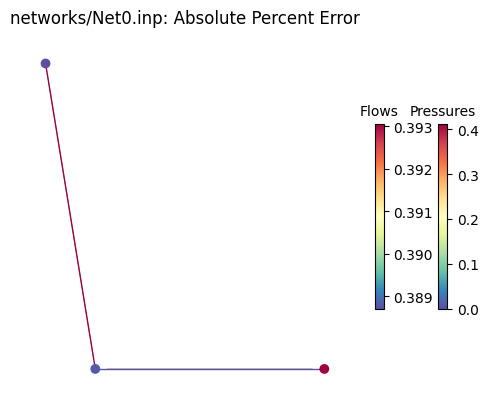

<Axes: title={'center': 'networks/Net0.inp: Absolute Percent Error'}>

In [ ]:
from utils import get_ape_from_pd_series

wntr.graphics.plot_network(
    wn,
    node_attribute=get_ape_from_pd_series(
        results_vqls.node["pressure"].iloc[0], results_epanet.node["pressure"].iloc[0]
    ),
    link_attribute=get_ape_from_pd_series(
        results_vqls.link["flowrate"].iloc[0],
        results_epanet.link["flowrate"].iloc[0],
    ),
    node_colorbar_label="Pressures",
    link_colorbar_label="Flows",
    node_size=50,
    title=f"{inp_file}: Absolute Percent Error",
    node_labels=False,
)

### Plot pressures and flow rates

Let's check graphically the equivalence of the results.

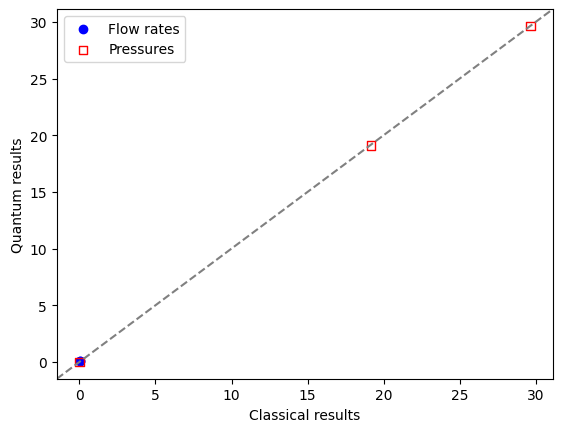

([0.05000009, 0.05, 29.64769, 19.167675, -9.338379e-07],
 [0.05019662, 0.050194357, 29.645105, 19.088566, -9.338379e-07])

In [6]:
import matplotlib.pyplot as plt

plt.scatter(
    results_classical[:n_pipes],
    results_quantum[:n_pipes],
    label="Flow rates",
    color="blue",
    marker="o",
)
plt.scatter(
    results_classical[n_pipes:],
    results_quantum[n_pipes:],
    label="Pressures",
    color="red",
    marker="s",
    facecolors="none",
)
plt.axline((0, 0), slope=1, linestyle="--", color="gray", label="")
plt.xlabel("Classical results")
plt.ylabel("Quantum results")
plt.legend()
plt.show()

results_classical, results_quantum